# Atmospheric Turbulence

Simulation of atmospheric turbulence's effects on point image source

From http://www.roe.ac.uk/roe/workshop/2011/presentations/tue-pm3-richard-wilson.pdf

- Create 2D array of random complex numbers, normal distribution, mean=0, variance=1
- Phase power spectrum: $\phi(k) = 0.0229r_{0}^{\frac{5}{3}}k^{\frac{-11}{3}}$
- Multiply random numbers by $\sqrt{\phi(k)}$
- FFT to get array of phase fluctuations

Following Matlab example simulation here:  http://www.activeopticalsystems.com/docs/AN021_Kolmogorov%20Spectrum%20Turbulence%20Analysis.pdf

/home/niels/anaconda3/envs/speckle/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in power


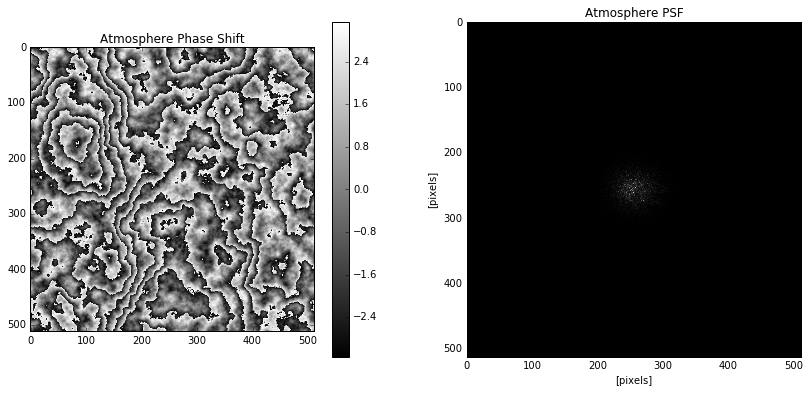

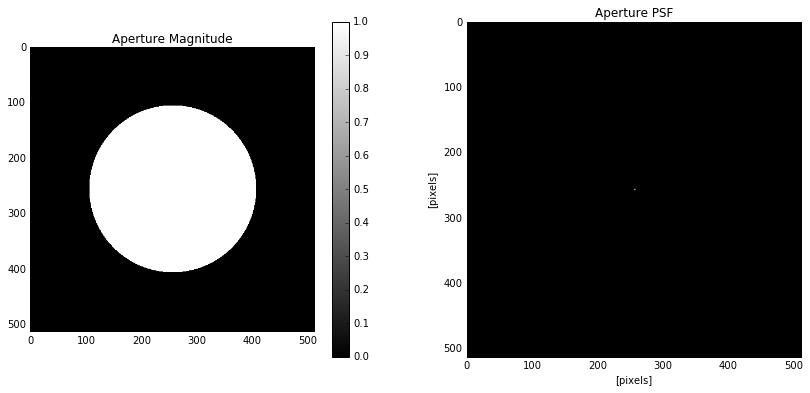

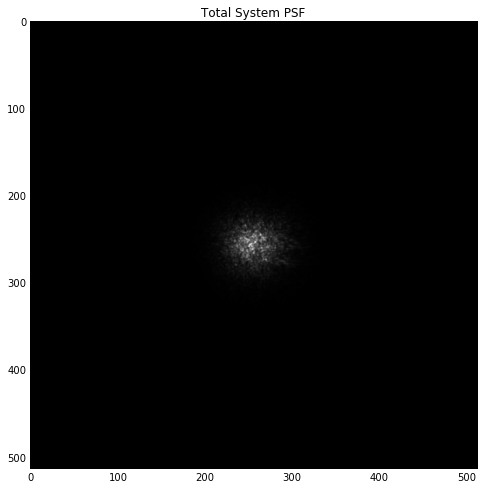

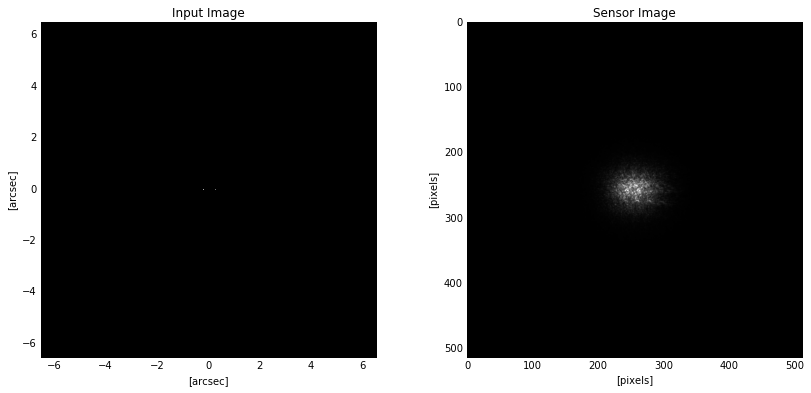

In [1]:
# Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema

%matplotlib inline

# Image specs
size = 512
center = int(size/2)

# Creating Binary Star Input Image
# For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
platescale = 0.02544 # Plate scale in arcsec/pixel
rho = 0.5 # Set separation in arcseconds
phi = 0 # Set angle in degrees

## Input star generation
# Calculate coordinates of stars
x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
x1 = center + x
y1 = center + y
x2 = center - x
y2 = center - y    
# Empty input image
input_img = np.zeros((size,size)) 
# Place stars on image
input_img[y1,x1] = 255 
input_img[y2,x2] = 255 

## Phase screen creation:
# Spectral generation
# Total sample array size
d_aperture = 2.1 
# Fried parameter
r0 = 0.10
# Number of pixels
nxy = 512 
# Spatial sample resolution
dxy = d_aperture/nxy
# Spatial frequency resolution
df = 1/(d_aperture) 
# Image sample indices array
#x = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), dxy )
# Spatial Frequency indices array
xf = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), df )
# Meshgrid of spatial frequency domain
[xx,yy]=np.meshgrid(xf,xf)
# Radius from center meshgrid
rr = (np.sqrt(np.power(xx,2)+np.power(yy,2)))
# Calculate Kolmogorov spectral density
PSD = np.power(rr,-11/3)
PSD = np.multiply(0.023/(r0**(5/3)),PSD)
# Set DC component to 0 (previous calc attempts to set to 1/0)
PSD[int(nxy/2),int(nxy/2)] = 0 
# Generate Random noise image
random = np.random.normal(0,1,(nxy,nxy)) + 1j*np.random.normal(0,1,(nxy,nxy))  
# Filter random noise image
phase = np.real(ifft2(fftshift(np.sqrt(PSD)*random)*nxy*nxy))
# Create complex phase screen
screen_atmosphere = np.exp(np.multiply(1j,phase))

## Telescope aperture creation:
# Draw aperture image
# Create meshgrid of coordinates
yy, xx = np.mgrid[:size, :size] 
# Calculate grid of distances from circle center
circle = (xx - center) ** 2 + (yy - center) ** 2 
# Draw boolean circle
circle = circle < (150)**2 
# Convert boolean circle to int
screen_aperture = circle.astype(np.int64) 

## Calculate Output Image
# Calculate PSF of atmosphere and aperture
psf_atmosphere = fftshift(np.power(np.abs(fft2(screen_atmosphere)),2)) 
psf_aperture = fftshift(np.power(np.abs(fft2(screen_aperture)),2)) 
# Calculate total PSF of system
psf = fftconvolve(psf_atmosphere,psf_aperture)
# Save center 512x512 image
psf = psf[center:center+size,center:center+size] 

# Convolve atmosphere PSF with input image using FFT
sensor_img = fftconvolve(input_img,psf)
# Save the center 512x512 image
sensor_img = sensor_img[center:center+size,center:center+size] 

#Plots
colormap = "gray"

plt.figure(figsize = (14,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(np.angle(screen_atmosphere), cmap=colormap)
plt.colorbar()
plt.title("Atmosphere Phase Shift")
plt.subplot(1,2,2)
plt.imshow(psf_atmosphere, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Atmosphere PSF")

plt.figure(figsize = (14,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(np.abs(screen_aperture), cmap=colormap)
plt.colorbar()
plt.title("Aperture Magnitude")
plt.subplot(1,2,2)
plt.imshow(psf_aperture, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Aperture PSF")

plt.figure(figsize = (8,8), dpi = 100)
plt.imshow(psf, cmap=colormap)
plt.title("Total System PSF")

plt.figure(figsize = (14,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(input_img, cmap=colormap, extent = (-6.513,6.513,-6.513,6.513))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(sensor_img, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Sensor Image")